In order to make use of SOM, we'll import a library called minisom

In [2]:
!pip3 install minisom

  Created wheel for minisom: filename=MiniSom-2.2.9-cp37-none-any.whl size=8595 sha256=b57dfc5539c6726146cbf8818487da7905f1f13c865679fe913d4d1344463cd7
  Stored in directory: /root/.cache/pip/wheels/de/a0/08/5234d6b02b29c561f62b6c985e2eb7d480fb0b92359a8c74e4
Successfully built minisom


In [257]:

%matplotlib inline

from time import time

import numpy as np
from minisom import MiniSom

from pylab import text,show,cm,axis,figure,subplot,imshow,zeros
from sklearn.metrics import accuracy_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns


In [321]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Let's inspect only 1024 first training samples in this notebook
X = X_train[:1024]
y = y_train[:1024]

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X:', X.shape)
print('y:', y.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
X: (1024, 28, 28)
y: (1024,)


In [334]:
EPOCHS = 60
LEARNING_RATE = 0.2


xsize = 16
ysize = 10


t0 = time()
som = MiniSom(xsize, ysize, 28*28 ,sigma=5, learning_rate=LEARNING_RATE,neighborhood_function='triangle')
som.train_random(X.reshape(-1,28*28), X.shape[0]*EPOCHS)
print('Time elapsed: %.2fs' % (time()-t0))

Time elapsed: 66.44s


In this section we specify in each of the neurons (bins) what is the leader image. we put the leader image into the bin, and if a better leader (one with less error) wanted to go into the same bin, we allow it to. Note that we keep the value of the best leaders in the dictionary labels, which we use to perform evaluations on

In [336]:
t0 = time()
wmap = {}
labels={}
qerrors = np.empty((xsize,ysize))
qerrors.fill(np.nan)
for idx,x in enumerate(X.reshape(-1,28*28)):
    (i,j) = som.winner(x)
    
    qe = np.linalg.norm(x-som._weights[i,j])
    if np.isnan(qerrors[i,j]) or qe<qerrors[i,j]:
        wmap[(i,j)] = idx
        labels[(i,j)] = y[idx]
        qerrors[i,j] = qe
print('Time elapsed: %.2fs' % (time()-t0))
print(labels)

Time elapsed: 0.59s
{(2, 7): 5, (11, 8): 0, (4, 4): 9, (15, 3): 1, (6, 2): 9, (7, 8): 2, (15, 9): 1, (2, 9): 3, (10, 3): 4, (0, 8): 3, (13, 3): 5, (0, 3): 3, (9, 6): 6, (9, 1): 7, (4, 9): 2, (14, 1): 8, (11, 5): 6, (8, 1): 9, (4, 5): 4, (11, 9): 0, (13, 5): 5, (3, 8): 2, (6, 1): 4, (11, 0): 7, (11, 3): 4, (3, 2): 3, (13, 0): 8, (10, 2): 7, (0, 7): 0, (12, 4): 8, (10, 6): 6, (5, 0): 7, (15, 7): 1, (15, 0): 8, (6, 0): 7, (7, 0): 7, (3, 4): 8, (7, 2): 9, (2, 5): 8, (2, 3): 9, (1, 8): 3, (1, 3): 3, (3, 0): 7, (14, 5): 6, (7, 4): 7, (15, 1): 8, (1, 0): 0, (8, 2): 9, (5, 4): 4, (15, 4): 1, (5, 5): 4, (11, 7): 0, (8, 5): 4, (12, 3): 5, (9, 7): 6, (15, 6): 1, (1, 1): 0, (0, 6): 0, (14, 8): 1, (10, 1): 7, (15, 8): 1, (1, 4): 3, (4, 7): 2, (15, 5): 1, (0, 5): 5, (4, 0): 7, (14, 0): 8, (2, 2): 5, (9, 2): 9, (0, 1): 0, (9, 3): 4, (8, 6): 6, (10, 0): 7, (12, 5): 6, (9, 0): 7, (11, 6): 6, (1, 9): 3, (11, 4): 4, (2, 6): 3, (0, 0): 0, (6, 3): 9, (3, 7): 2, (12, 8): 0, (4, 8): 2, (13, 8): 5, (14, 7): 7

In this section we show the ground-truth leaders of each of the bins

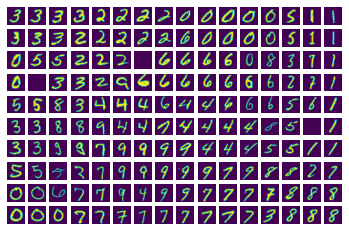

In [337]:
figure(facecolor='white')
cnt = 0
for j in reversed(range(ysize)):
	for i in range(xsize):
		subplot(ysize,xsize,cnt+1,frameon=False, xticks=[], yticks=[])
		if (i,j) in wmap:
			imshow(X[wmap[(i,j)]])
		else:
			imshow(zeros((28,28)))
		cnt = cnt + 1

In this section each image represents the raw image our algorithm came up with 

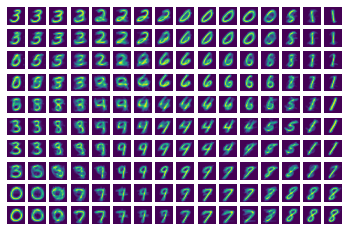

In [338]:
figure(facecolor='white')
cnt = 0
for j in reversed(range(ysize)):
	for i in range(xsize):
		subplot(ysize,xsize,cnt+1,frameon=False, xticks=[], yticks=[])
		imshow(som._weights[i,j].reshape(28,28))
		cnt = cnt + 1

In [339]:
y_pred = np.asarray([], dtype=np.uint8)

x_t = X_test
x_t = x_t.reshape(-1,28*28)
for i in range (len(y_test)):
  wn = som.winner(x_t[i])
  y_pred = np.append(y_pred, labels.get((wn[0],wn[1]), 0))

print(y_pred)

print(y_test)


[7 2 1 ... 9 5 6]
[7 2 1 ... 4 5 6]


In [340]:
print(f"accuracy: {accuracy_score(y_pred, y_test) * 100 :.2f}%")
print(f"rand index: {adjusted_rand_score(y_pred, y_test) * 100 :.2f}%")

accuracy: 74.52%
rand index: 55.31%


# Test any Image

change "num" to see original image and predicted reuslt for it

predicted: 5


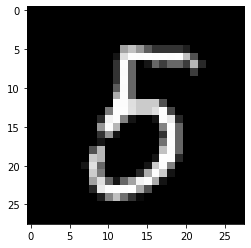

In [279]:
num = 45

X_m = X_test
img = X_m[num]

# And displaying the image
plt.imshow(img, cmap="gray")

wn = som.winner(X_m.reshape(-1,28*28)[num])


print(f"predicted: {labels[wn[0],wn[1]]}")
